<a href="https://colab.research.google.com/github/MirtoSpatha/Energy-Time-Series-Forecasting/blob/main/Energy_Demand_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Total Energy Demand (Load) Forecasting in a National Level**

Author: Myrto Spatha

This project is conducted for my Internship and is part of my Undergraduate Thesis in Transformer Neural Network Architecture.

The goal is to perform a **single hour forecasting** task for the **electricity demand in Spain** based on the actual load for the previous 24 hours in a period of 4 years (2015-2018) (**Univariate Time Series Forecasting**).

The **data** were collected by the following Kaggle dataset (https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather)  which contains energy and weather data in an hourly frequency for the time period 2015-2018 (**time series data**) (details in the Data Exploration and Cleaning Section).

The **models** I implement are the following: Linear Regression, Simple Dense Neural Network, Support Vector Machines, Transformer Neural Network Architecture. I made this assumption as there is no Kaggle notebook that implements these techniques for this dataset (except for Linear Regression which is used as a baseline model).

All those methods are trained until 2018-08-07 and are tested until 2018-12-31.

The **experiments** where operated in a Google Colab environment to get access to a free GPU and be able to share my code with others easily.

The following notebook presents a methodology for a beginner data analyst/machine learning engineer who wants to operate/specialize in the Energy Sector or in Time Series Data Analysis.

The preprocessing, visualization and feature engineering where based on the following Kaggle notebook: https://www.kaggle.com/code/dimitriosroussis/electricity-price-forecasting-with-dnns-eda

The simplified version of Transformer Architecture was based on the following project: https://github.com/mounalab/Multivariate-time-series-forecasting-keras/blob/main/Transformer.py


##Drive Mount and Imports

Data is mounted to the drive to be able to use it by the path /content/drive/MyDrive/Thesis/Transformer_Thesis/data.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Useful Library imports:

In [2]:
!pip install tensorflow_addons
!pip install xlwings

import pandas as pd
import numpy as np
from math import sqrt
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import xlwings as xw

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf

import tensorflow as tf
import tensorflow_addons as tfa
import keras

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 10.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Data Exploration and Cleaning

The used dataset contains time series data (year-month-day and hour in UTC timesystem) for the total electricity demand and generation in Spain stored in Mw. It also contains the price of electricity in dollars/Mwh as well as a prediction for the total load (demand), the price of electricity and the generation of electricity by wind and solar power.

### Data Load

Data is Loaded from Drive and gets stored into a DataFrame.

In [3]:
path = "/content/drive/MyDrive/Thesis/Transformer_Thesis/data/energy_dataset.csv"
df = pd.read_csv(path, parse_dates=['time'])

df

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89


### Data Exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
generation biomass,35045.0,383.513540,85.353943,0.00,333.0000,367.00,433.00,592.00
generation fossil brown coal/lignite,35046.0,448.059208,354.568590,0.00,0.0000,509.00,757.00,999.00
generation fossil coal-derived gas,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation fossil gas,35046.0,5622.737488,2201.830478,0.00,4126.0000,4969.00,6429.00,20034.00
generation fossil hard coal,35046.0,4256.065742,1961.601013,0.00,2527.0000,4474.00,5838.75,8359.00
generation fossil oil,35045.0,298.319789,52.520673,0.00,263.0000,300.00,330.00,449.00
generation fossil oil shale,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation fossil peat,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation geothermal,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation hydro pumped storage aggregated,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The 'time' column, which we also want to function as the index of the observations in a time-series, has not been parsed correctly and is recognized as an object.

In [6]:
df['time'] = pd.to_datetime(df['time'], utc=True, infer_datetime_format=True)
df = df.set_index('time')

Test if total generation amount is the same as total load.

For an energy system to be feasible, we need the total generation to be greater or equal to the total load.

In [7]:
df['generation all'] = df['generation biomass'] + df['generation fossil brown coal/lignite'] + df["generation fossil hard coal"] + df["generation nuclear"] + df["generation solar"] + df["generation hydro pumped storage consumption"] + df["generation fossil gas"] + df["generation fossil oil"] + df["generation hydro run-of-river and poundage"] + df["generation hydro water reservoir"] + df["generation other"] + df["generation other renewable"] + df["generation waste"] + df["generation wind onshore"]

In [8]:
print(df["generation all"] - df["total load actual"])

print(df["generation all"].sum())
print(df["total load actual"].sum())

time
2014-12-31 23:00:00+00:00    2866.0
2015-01-01 00:00:00+00:00    3436.0
2015-01-01 01:00:00+00:00    4062.0
2015-01-01 02:00:00+00:00    3937.0
2015-01-01 03:00:00+00:00    4356.0
                              ...  
2018-12-31 18:00:00+00:00   -4238.0
2018-12-31 19:00:00+00:00   -4522.0
2018-12-31 20:00:00+00:00   -4084.0
2018-12-31 21:00:00+00:00   -3053.0
2018-12-31 22:00:00+00:00   -1850.0
Length: 35064, dtype: float64
1003515456.0
1005196411.0


### Drop Unusable Columns

Inside the dataset there are columns that have no values, or columns that have very little values with no significance. Those columns are irrelevant to the dataset and thus need to be dropped.

In [9]:
# drop nan columns

df.replace("", np.nan, inplace=True)

df.dropna(how='all', axis=1, inplace=True)

In [10]:
# drop mostly zero columns
nullcol = []
for item in df.columns:
  if(item == 'time'):
    continue
  if (len(df[df[item] != 0]) < 20):
    nullcol.append(item)
    for i in range(len(df[item])):
      if (df[item][i] !=0):
        value = df[item][i]

In [11]:
col = [item for item in nullcol]
df = df.drop(columns = col)

df.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,generation all
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,49.0,196.0,6378.0,17.0,6436.0,26118.0,25385.0,50.10,65.41,28251.0
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,50.0,195.0,5890.0,16.0,5856.0,24934.0,24382.0,48.10,64.92,27818.0
2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,...,50.0,196.0,5461.0,8.0,5454.0,23515.0,22734.0,47.33,64.48,26796.0
2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,...,50.0,191.0,5238.0,2.0,5151.0,22642.0,21286.0,42.27,59.32,25223.0
2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,...,42.0,189.0,4935.0,9.0,4861.0,21785.0,20264.0,38.41,56.04,24620.0


### Fill Missing Values

The method we use to fill missing values is linear interpolation (the missing value is replaced by the mean of the previous and next value).

In [12]:
dfn = df.loc[:,df.columns!='time']
df_filled = dfn.interpolate("linear")

In [13]:
df_filled

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,generation all
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,49.0,196.0,6378.0,17.0,6436.0,26118.0,25385.0,50.10,65.41,28251.0
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,50.0,195.0,5890.0,16.0,5856.0,24934.0,24382.0,48.10,64.92,27818.0
2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,...,50.0,196.0,5461.0,8.0,5454.0,23515.0,22734.0,47.33,64.48,26796.0
2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,...,50.0,191.0,5238.0,2.0,5151.0,22642.0,21286.0,42.27,59.32,25223.0
2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,...,42.0,189.0,4935.0,9.0,4861.0,21785.0,20264.0,38.41,56.04,24620.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,63.0,...,85.0,277.0,3113.0,96.0,3253.0,30619.0,30653.0,68.85,77.02,26415.0
2018-12-31 19:00:00+00:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,62.0,...,33.0,280.0,3288.0,51.0,3353.0,29932.0,29735.0,68.40,76.16,25213.0
2018-12-31 20:00:00+00:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,61.0,...,31.0,286.0,3503.0,36.0,3404.0,27903.0,28071.0,66.88,74.30,23987.0


## Visualization

### Useful visualizations and insights

In [14]:
# Define a function to plot different types of time-series

def plot_series(df=None, column=None, series=pd.Series([]),
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series
    created by the user. The user can define either the 'df' and the 'column'
    or the 'series' and additionally, can also define the 'label', the
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

<ipython-input-14-12e47236ed59>:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def plot_series(df=None, column=None, series=pd.Series([]),


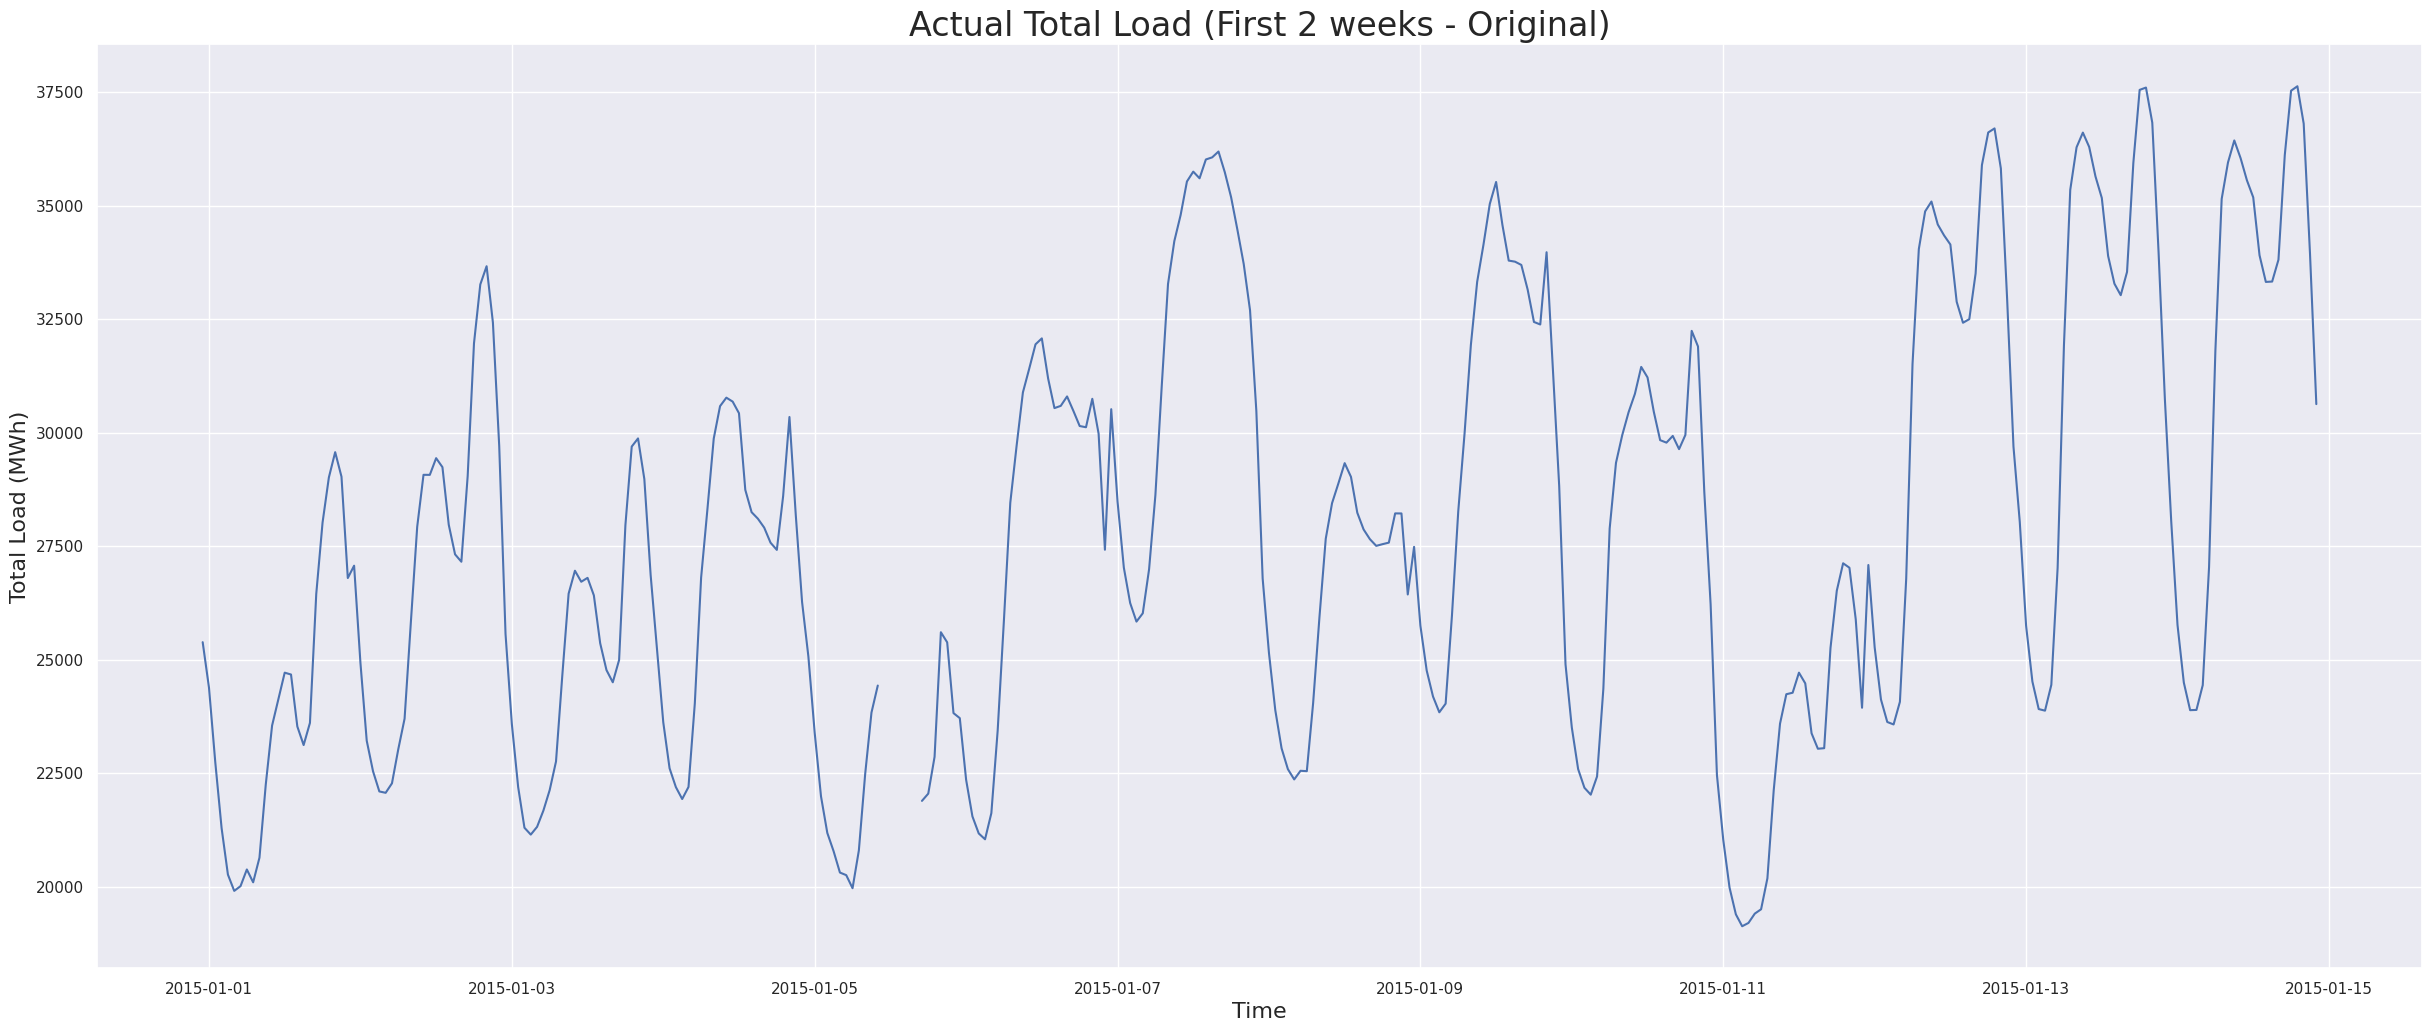

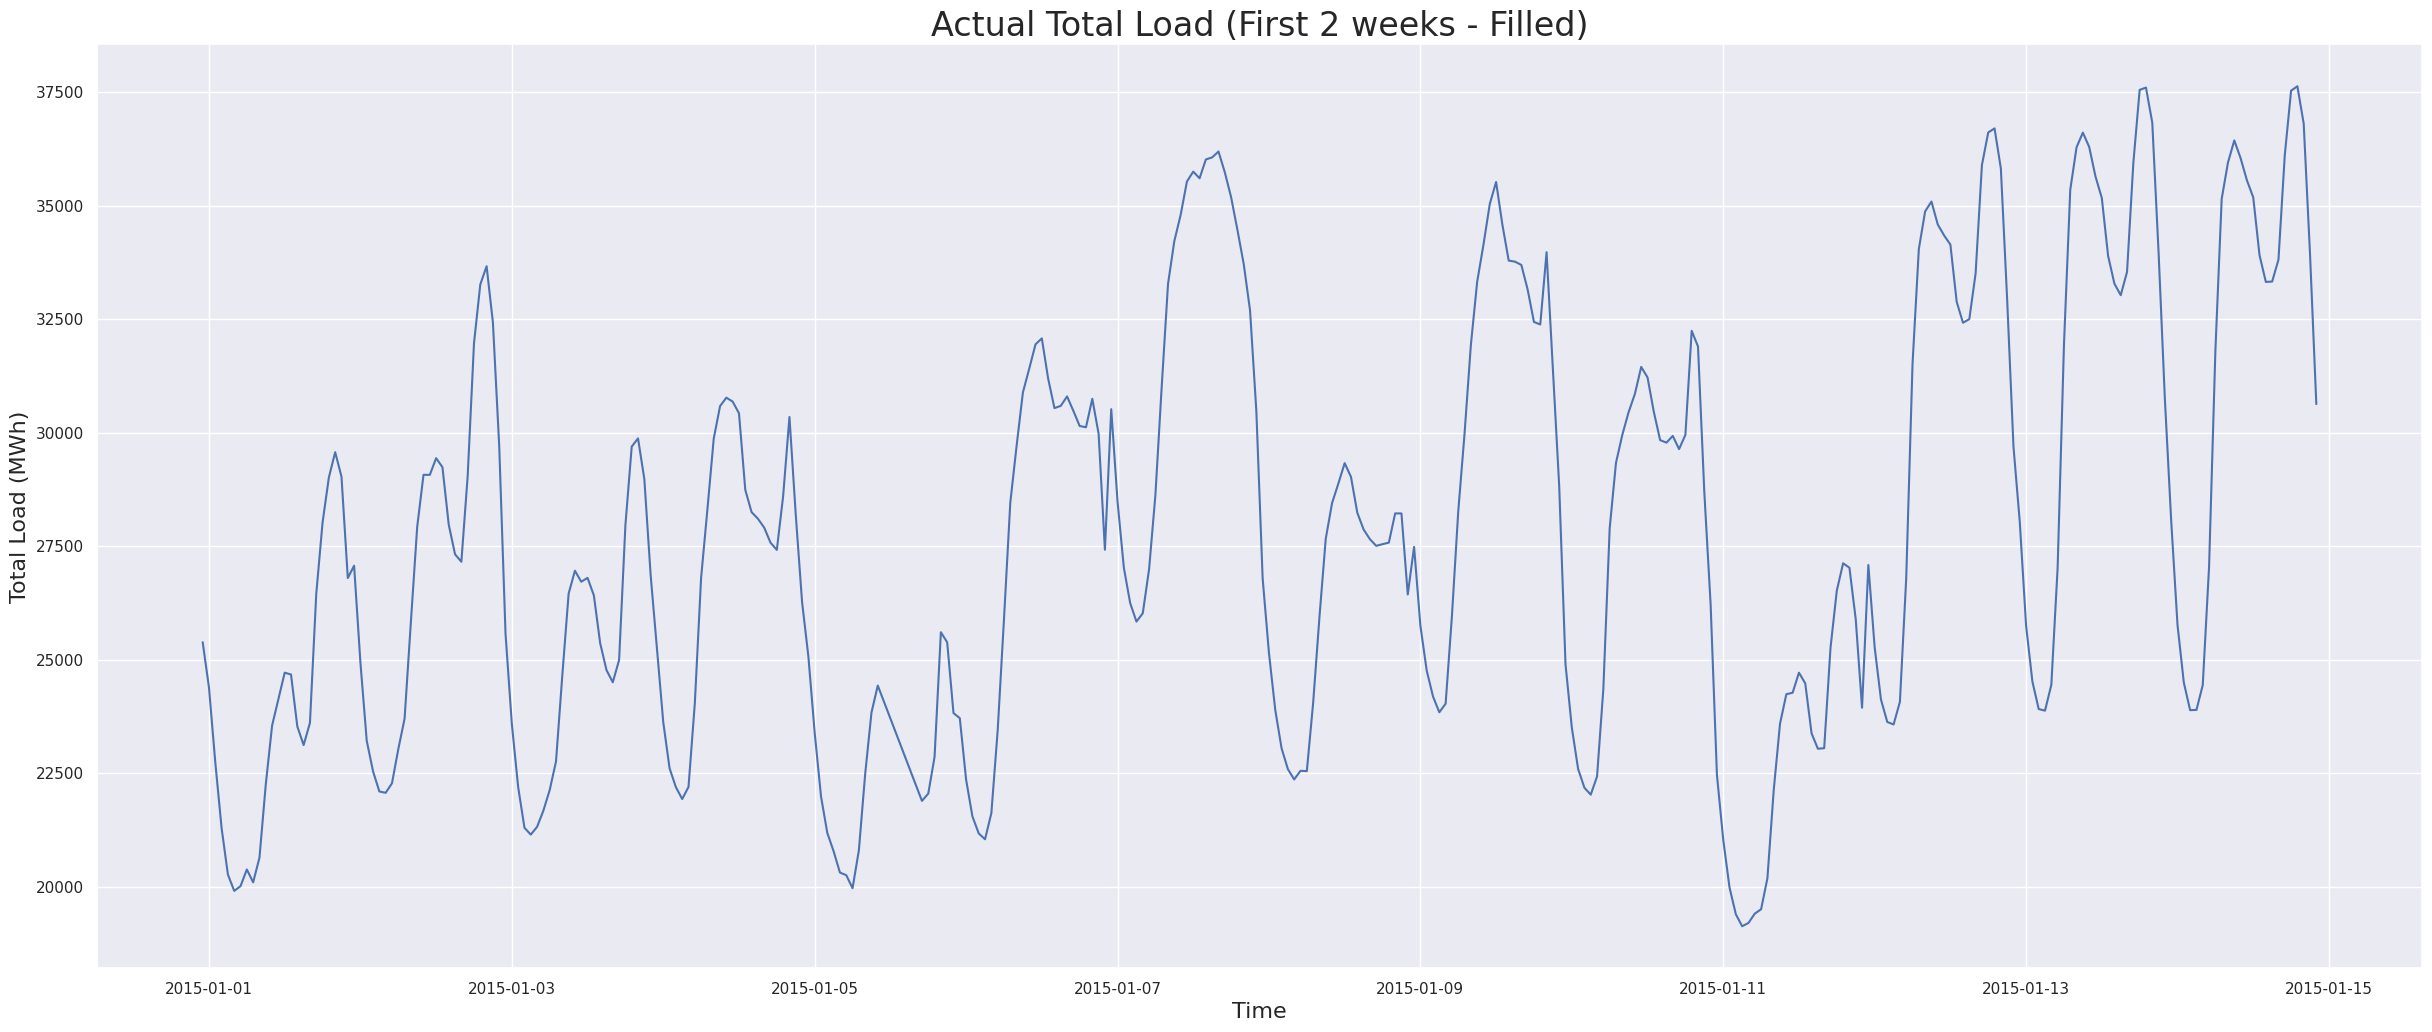

In [15]:
# Zoom into the plot of the hourly (actual) total load before filling missing values
ax = plot_series(df=df, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks - Original)', end=24*7*2)
plt.show()

# Zoom into the plot of the hourly (actual) total load after filling missing values
ax = plot_series(df=df_filled, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks - Filled)', end=24*7*2)
plt.show()

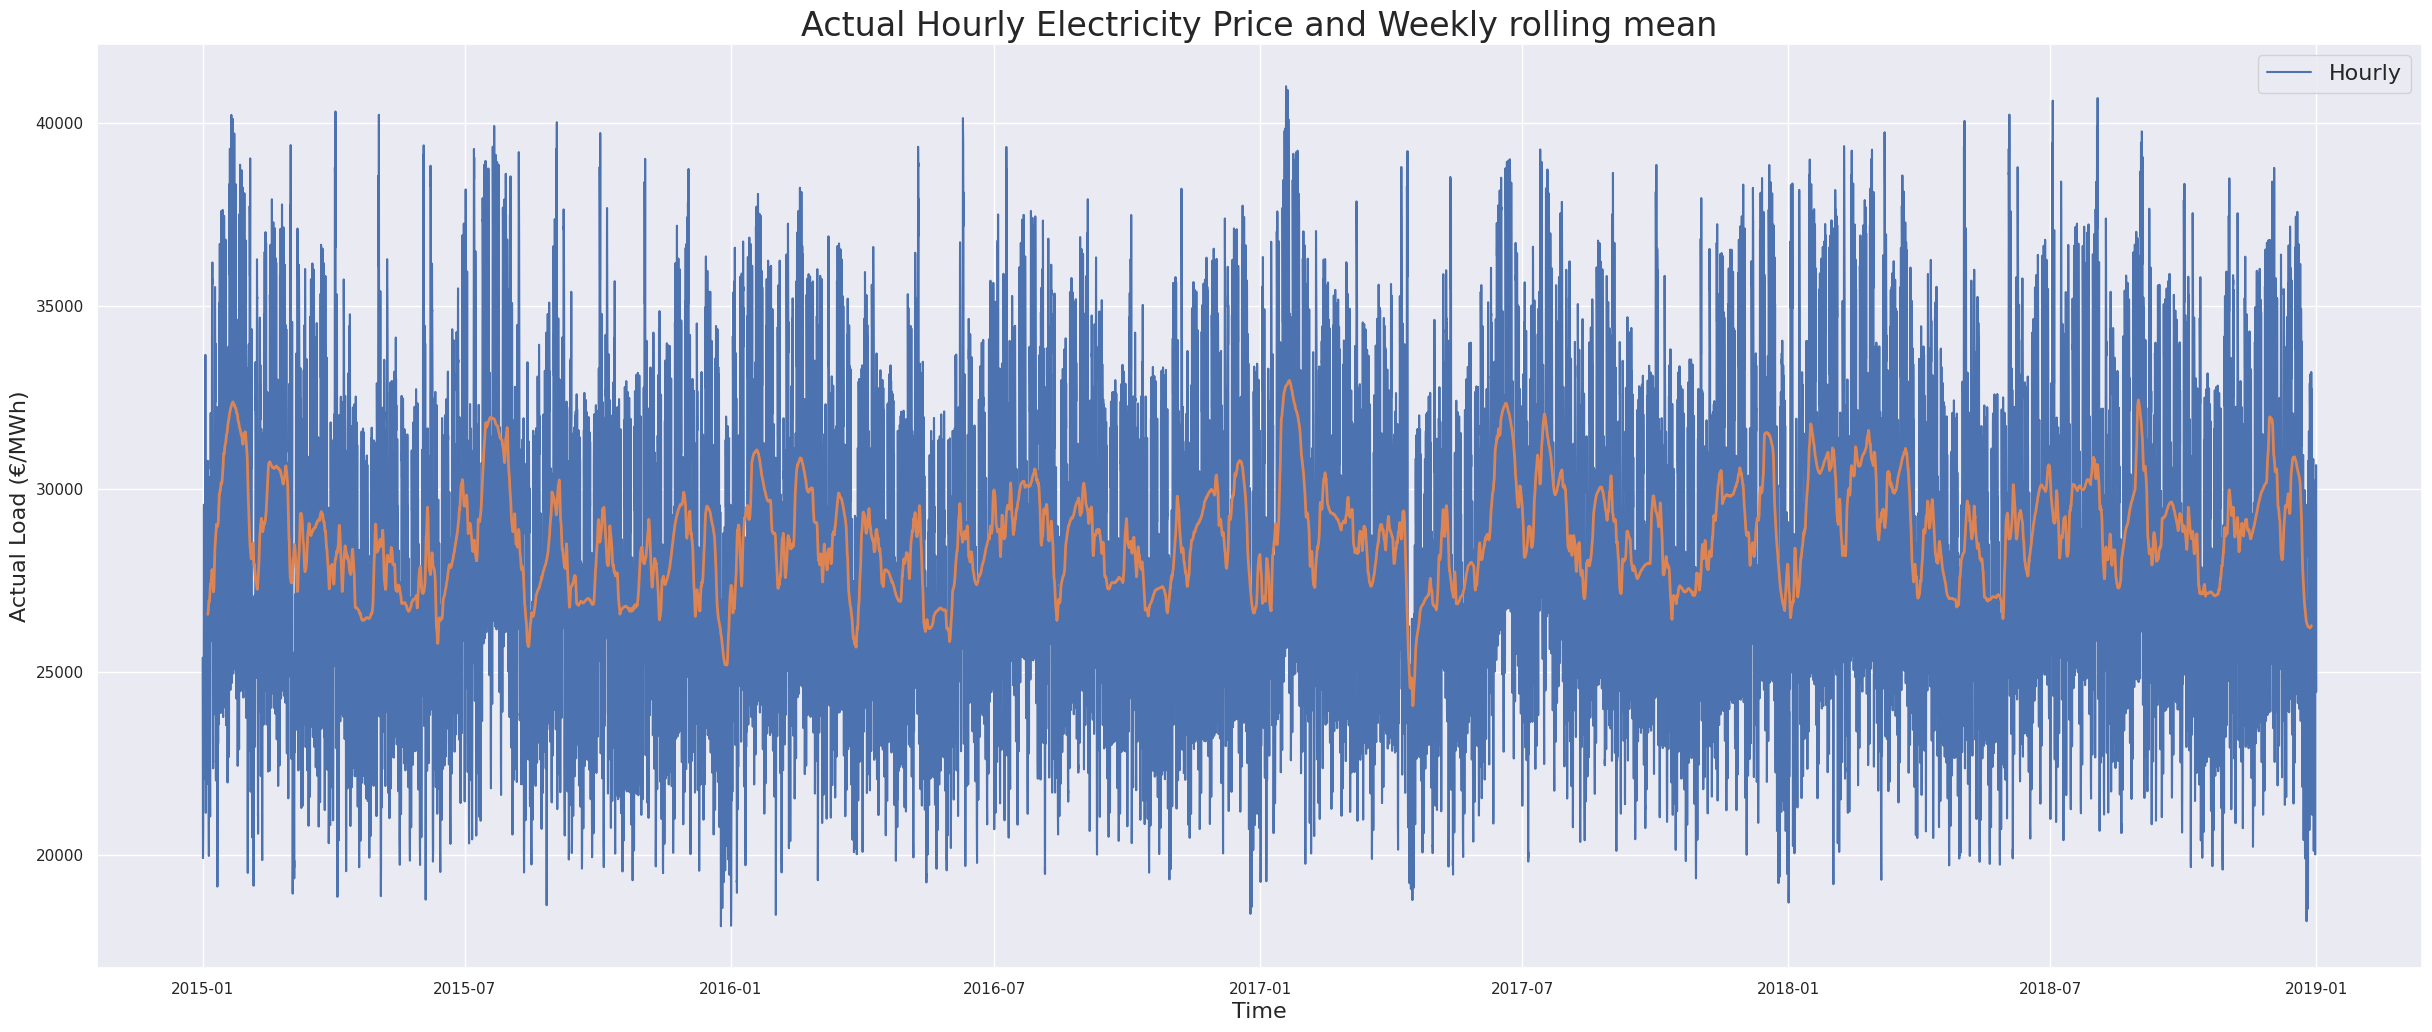

In [16]:
# Plot the hourly actual electricity load, along with the weekly rolling mean
rolling = df_filled['total load actual'].rolling(24*7, center=True).mean()
ax = plot_series(df_filled, 'total load actual', label='Hourly', ylabel='Actual Load (€/MWh)',
                 title='Actual Hourly Electricity Price and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

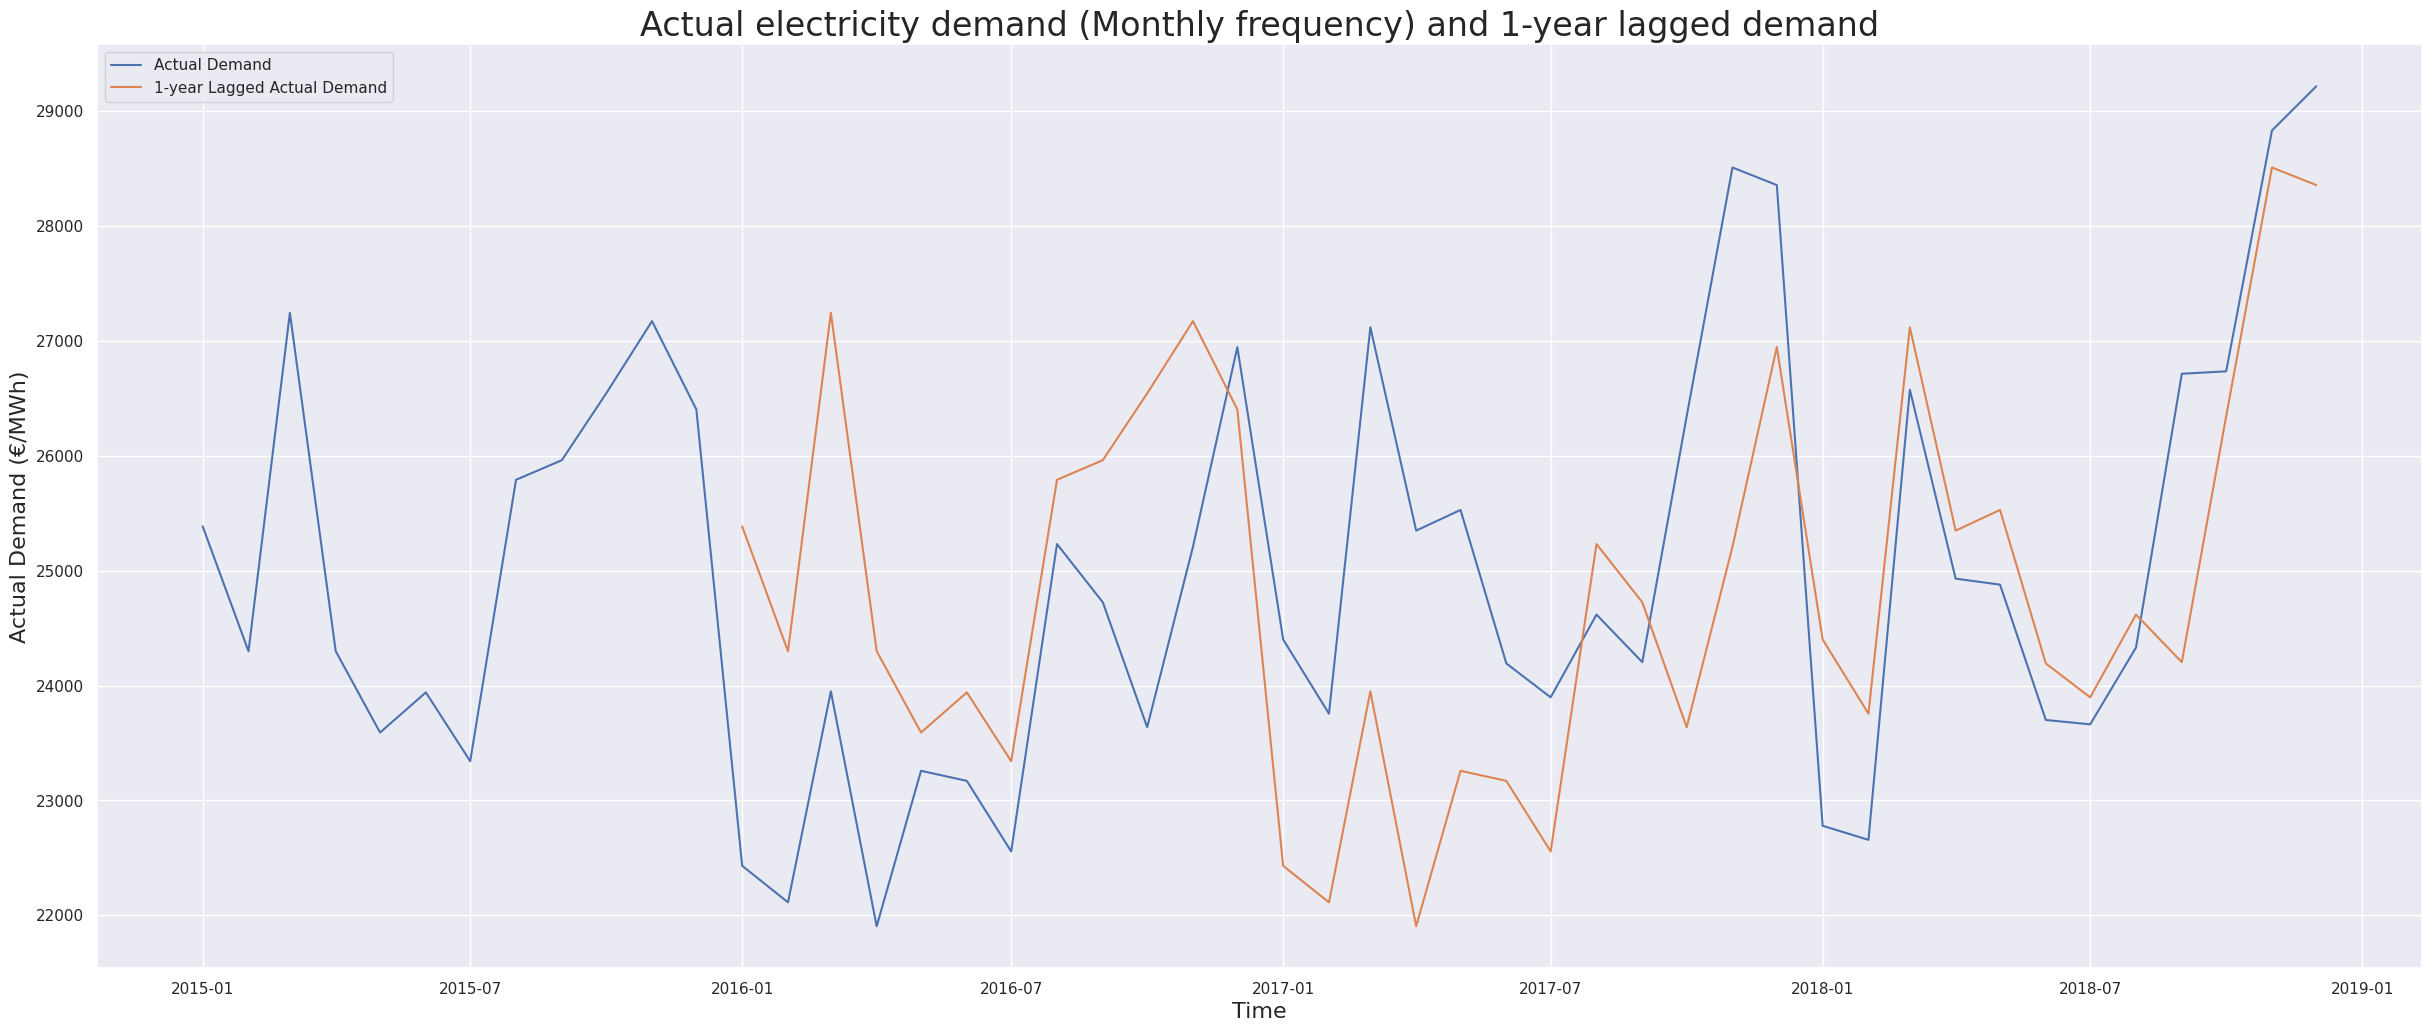

In [17]:
# Plot the electricity demand (monthly frequence) along with its 1-year lagged series

monthly = df_filled['total load actual'].asfreq('M')
ax = plot_series(series=monthly, ylabel='Actual Demand (€/MWh)',
                 title='Actual electricity demand (Monthly frequency) and 1-year lagged demand')
shifted = df_filled['total load actual'].asfreq('M').shift(12)
ax.plot(shifted, label='Hourly')
ax.legend(['Actual Demand', '1-year Lagged Actual Demand'])
plt.show()

The figure above shows the (resampled) monthly frequency of the actual electricity load, along with its 1-year lagged monthly frequency. From this, we can see that there are some **seasonal patterns at the monthly scale**, as certain "spikes" in the time-series take place in exactly the same months. This means that it would be a good idea to create a new feature for the months. If the figure displayed the 1-year lagged actual energy price at hourly or weekly time scales, we would -of course- see no such seasonal patterns.

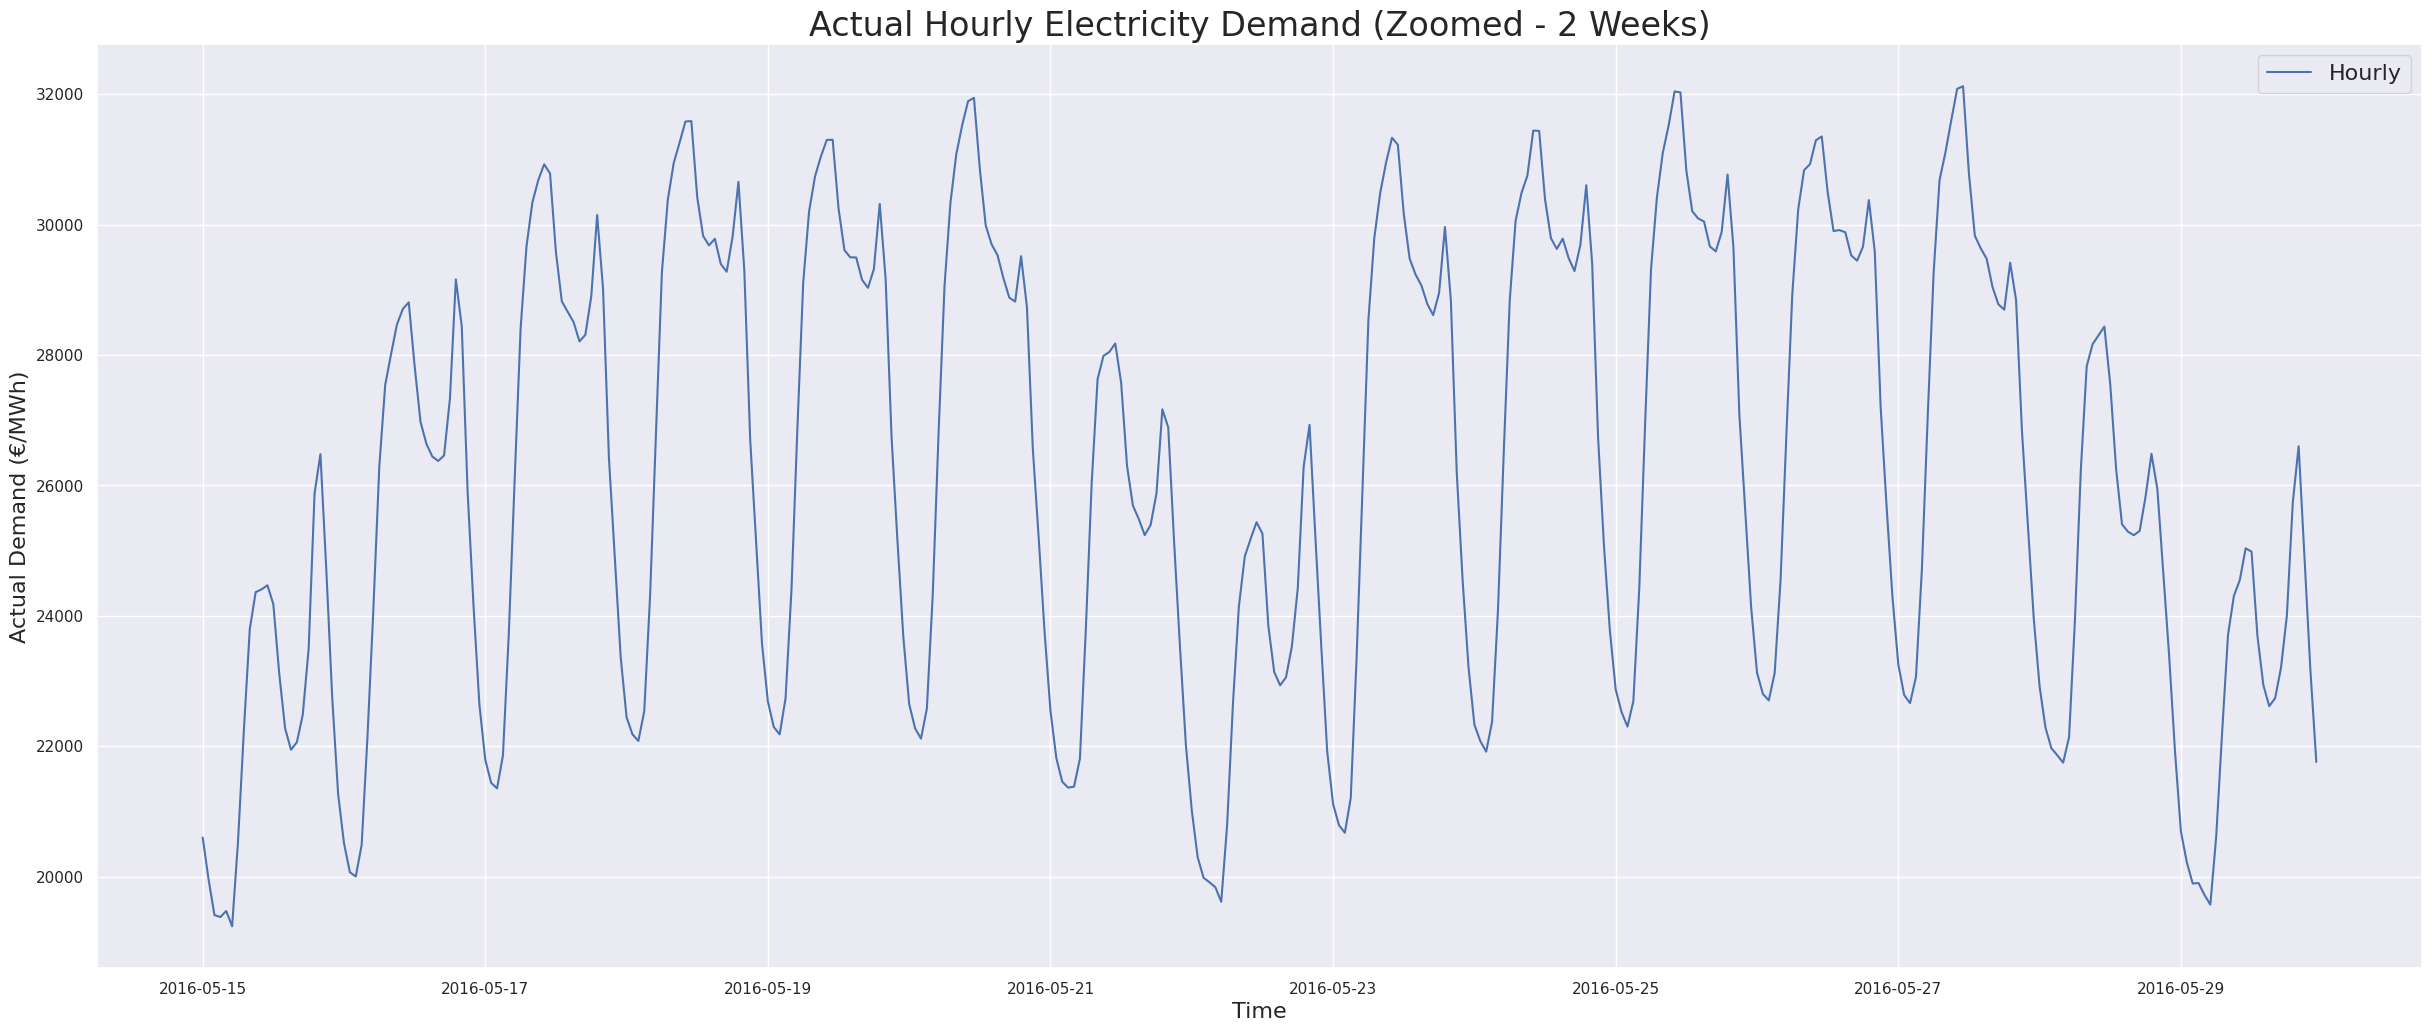

In [18]:
# Plot the actual electricity demand at a daily/weekly scale

ax = plot_series(df_filled, 'total load actual', label='Hourly', ylabel='Actual Demand (€/MWh)',
                 start=1 + 24* 500, end=1 + 24* 515,
                 title='Actual Hourly Electricity Demand (Zoomed - 2 Weeks)')
plt.show()

In the figure above, we have plotted that actual hourly electricity demand from 15/05/2016 (Sunday) at 00:00 up to 29/05/2016 (Sunday) at 23:00, i.e. two weeks of data. We can observe that there are many patterns and periodicities, such as:
- A periodicity from week to week, as the electricity price tends to be higher during business days and lower during weekends and especially during sundays.
- An intradyay periodicity, as the price is higher during the day and lower during the night.
- A periodicity within the business hours, as in some cases the electricity price drops for a few hours, which is probably due to "siesta", the traditional lunch break between 01:30PM and 04:30PM, as Spain does not strictly follow the 9AM-5PM business day.

Later on, we will make sure that we will generate features which contain these kinds of information.

In [ ]:
# Plot the percentage of the hourly change in the actual electricity demand

change = df_filled['total load actual'].div(df_filled['total load actual'].shift(1)).mul(100)
ax = plot_series(series=change, ylabel='Hourly Change (%)',
                 title='Percentage of the hourly change in the actual electricty demand')
plt.show()

From the figure above, we can see that the change in the actual demand from hour to hour is in most of the cases between -20% (actual price * 0.80) and +20% (actual price * 1.20). However, there are also very few outliers which show that the demand drops (-60%) or rises (> +60%) suddenly.

In [ ]:
# Plot the histogram of the actual electricity load

ax = df_filled['total load actual'].plot.hist(bins=18, alpha=0.65)

In the figure above, we can see that the actual energy demand roughly follows a bimodal distribution and thus, should be transformed to a normal distribution. We also have to make sure that the time series does not require any other kinds of transformations. More specifically, we will check whether the time series of energy price is stationary, after visualizing its decomposed component time-series.
We see that there also some outliers (values less than 20000 and more than 40000).

Decomposition and stationarity tests

In [ ]:
# Decompose the electricity demand time series

res = sm.tsa.seasonal_decompose(df_filled['total load actual'], model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

In [ ]:
# Decompose the log electricity load time-series

res = sm.tsa.seasonal_decompose(np.log(df_filled['total load actual']), model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

The **Augmented Dickey-Fuller (ADF) test**, a type of unit root test, determines how strongly a time series is defined by a trend. Its hypotheses are the following:
- **Null Hypothesis** $H_{0}$: There is a unit root in the time series, i.e. the series is autocorrelated with (r=1), a time dependent structure and thus, is not stationary.
- **Alternate Hypothesis** $H_{1}$: The time series has no unit root and is either stationary or can be made stationary using differencing.

In [ ]:
y = df_filled['total load actual']
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

The ADF statistic (-21.420316) is less than the critical value at 1% (-3.430537) and thus, we can say that **we reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that there is not a root-unit in the time series and thus, that it is either stationary or could be made stationary with 1st order differencing (difference-stationary).

The **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test**, follows the opposite logic from Augmented Dickey-Fuller test and checks for  stationarity. Its hypotheses are the following:
- **Null Hypothesis** $H_{0}$: The time series is level, i.e. it is stationary around a constant.
- **Alternate Hypothesis** $H_{1}$: There is a unit root in the time series and thus it not stationary.

In [ ]:
kpss_test = kpss(y, regression='c') #, lags='legacy'
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

The KPSS statistic (0.86966) is higher than the critical value at 1% (0.739) and thus, we can say that **we cannot reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that the time series is stationary or stationary around a constant.

Both tests concluded that the electricity load time series is stationary, while it is also true that deep neural networks can handle such properties in a more forgiving way compared to ARIMA models.

### Autocorrelation, partial autocorrelation and cross-correlation

Σχόλιο: Μπορώ να χρησιμοποιήσω τη μέθοδο συσχέτισης Pearson ενώ η κατανομή του load είναι bimodal?

We can calculate the correlation for time series observations with observations with previous time steps. This process is called autocorrelation or serial correlation.

We also calculate the correlation . This procces is called partial correlation.

In [ ]:
# Plot autocorrelation and partial autocorrelation plots

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df_filled['total load actual'], lags=50, ax=ax1)
plot_pacf(df_filled['total load actual'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

In [ ]:
cross_corr = ccf(df_filled['total load actual'], df_filled['price actual'])
plt.plot(cross_corr[0:50])
plt.show()

For simplicity, we will just work with the correlations between the electricity load and the other features at each given hour.

In [ ]:
# Find the correlations between the electricity load and the rest of the features

correlations = df_filled.corr(method='pearson')
print(correlations['total load actual'].sort_values(ascending=False).to_string())

From the above, we can already see some very interesting correlations among the energy demand that we want to predict and the rest of the features. For example, the total generation of energy is positively correlated with the electricity demand. In contrast, the amount of storage energy consumed through hydroelectric pumping is negatively correlated with the energy demand.

In [ ]:
# Plot Pearson correlation matrix

correlations = df_filled.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

While we cannot make a lot out of the above correlation matrix, we can observe that there quite a lot of features that are highly correlated with each other.

In [ ]:
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

What we can observe, is that apart from the forecasted features, the only features that are highly correlated are the total load and the total generation as well as the generation from hard coal and brown coal.

## Feature Engineering

This selection is useful for someone who wants to perform multivariate time series forecasting.

### Feature Generation

The generation from hard coal and brown coal are highly correlated, so we concatenate them into one column.

In [ ]:
# concat coal columns (they have high correlation)
df_filled['generation coal all'] = df_filled['generation fossil hard coal'] + df_filled['generation fossil brown coal/lignite']
df_filled = df_filled.drop(['generation fossil hard coal', 'generation fossil brown coal/lignite'], axis = 1)

## Data Split

We split the data so that 90% of it is the train set and the rest 10% is the test set.

The data needs to be split in chronological order for the models to take into account the historical data to predict the next data point accurately.

In [ ]:
num_train_samples = int(0.9 * len(df_filled))
print(num_train_samples)
num_test_samples = len(df_filled) - num_train_samples
print(num_test_samples)

### Normalization / Scaling:

In [ ]:
df_scaled = df_filled

In [ ]:
mean = df_filled[:num_train_samples].mean(axis=0)
print(mean)
df_filled -= mean
std = df_filled[:num_train_samples].std(axis=0)
print(std)
df_filled /= std

### Windowing

Time Series Data needs to be split in sliding windows in order to permit to the models to know to which historical values to focus on to compute the next value.

For each value that needs to be predicted, the model needs to take as input the previous 24 hours (24 data points).

So, we have to create sliding windows of samples and target sets (24 samples and one target in each window).

We also split the train and test sets into batches of 256 values each. The batches are useful for the models to compute results in small parts of the dataset so that the prediction can be more accurate.

In [ ]:
sequence_length = 24
delay = sequence_length -1
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    df_filled['total load actual'][:-delay],
    df_filled['total load actual'][delay:],
    sampling_rate = 1,
    sequence_length=24,
    shuffle=False,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    df_filled['total load actual'][:-delay],
    df_filled['total load actual'][delay:],
    sampling_rate = 1,
    sequence_length=24,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples)

In [ ]:
for sample, target in train_dataset:
    print("samples shape:", sample.shape)
    print("targets shape:", target.shape)
    break

train_ds = train_dataset.unbatch()
samples = np.array(list(train_ds.map(lambda x, y: x)))
targets = np.array(list(train_ds.map(lambda x, y: y)))

In [ ]:
for sample, target in test_dataset:
    print("samples shape:", sample.shape)
    print("targets shape:", target.shape)
    break

test_ds = test_dataset.unbatch()
test_samples = np.array(list(test_ds.map(lambda x, y: x)))
test_targets = np.array(list(test_ds.map(lambda x, y: y)))

## Models

### Common Functions

Training Loss and Metrics Visualization method (this function is used after every model to observe its learning curve):

In [ ]:
def plot_model_rmse_and_loss(history):

    # Evaluate train accuracies and losses

    train_rmse = history.history['root_mean_squared_error']

    train_loss = history.history['loss']

    # Visualize epochs vs. train accuracies and losses

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.legend()
    plt.title('Epochs vs. Training RMSE')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.legend()
    plt.title('Epochs vs. Training Loss')

    plt.show()

Training Function:

With compile fuction we configure the model with some parameters (optimizer to adjust model weights and minimize the loss, loss to monitor the performance of the optimizer, metrics to monitor the accuracy of the model) to make the training process easier.

Then, with fit function we insert our train data to the model and it starts "learning". We also add an early stopping parameter (stops training in epoch if the loss does not improve within 50 batches iterations) and a checkpoint parameter to save the best model with minimal error.

In [ ]:
def train(model, dataset, lr, checkpoint, num_epochs, num_batch):
  checkpoint_dir = checkpoint

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss='mean_squared_error', metrics = [tfa.metrics.RSquare(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanAbsolutePercentageError()])

  # Stop training if error does not improve within 50 iterations
  early_stopping_monitor = tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)

  # Save the best model ... with minimal error
  filepath = checkpoint_dir+datetime.now().strftime('%d%m%Y_%H:%M:%S')+".hdf5"
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')


  history = model.fit(dataset,epochs=num_epochs,batch_size=num_batch, verbose=1, callbacks = [early_stopping_monitor, checkpoint])

  #print('loss: {0}, rmse: {1}, r2: {2}, mae: {3}, mape: {4}'.format(history.history['loss'][-1], history.history['root_mean_squared_error'][-1]), history.history['r_squared'][-1], history.history['mean_absolute_error'][-1], history.history['mean_absolute_percentage_error'][-1])
  plot_model_rmse_and_loss(history)
  return(model, history)

Testing Function:

This method predicts the next hour value in the test data and prints the metrics results. This step is useful to evaluate the model's performance to unseen data.

The metrics are the following:
1. **Mean Squared Error**: Finds the average of the squared difference between the target value and the value predicted by the regression model. It’s fundamentally more prone to outliers than other metrics and it penalizes even small errors by squaring them.
2. **R^2 Score**
3. **Root Mean Squared Error**
4. **Mean Absolute Error**: Finds the average of the difference between the ground truth and the predicted values. It doesn’t exaggerate errors.
5. **Mean Absolute Percentage Error**

In [ ]:
def test(model, data):

  results ={}

  results['predictions'] = model.predict(data)
  print(len(results['predictions']))
  #results['predictions'] = pd.DataFrame(results['predictions'])
  #results['predictions'].index = pd.RangeIndex(df.index[num_train_samples:][0],df.index[num_train_samples:][len(results['predictions'])])
  test_data = data.unbatch()
  test_data = np.array(list(test_data.map(lambda x, y: y)))
  test_data = test_data.reshape(len(test_data),1)
  test_data = tf.convert_to_tensor(test_data)
  pred = tf.convert_to_tensor(results['predictions'])

  loss = tf.keras.metrics.MeanSquaredError()
  loss.update_state(test_data, pred)
  results['loss'] = float(loss.result())
  r2 = tfa.metrics.RSquare()
  r2.update_state(test_data, pred)
  results['r2'] = float(r2.result())
  rmse = tf.keras.metrics.RootMeanSquaredError()
  rmse.update_state(test_data, pred)
  results['rmse'] = float(rmse.result())
  mae = tf.keras.metrics.MeanAbsoluteError()
  mae.update_state(test_data, pred)
  results['mae'] = float(mae.result())
  mape = tf.keras.metrics.MeanAbsolutePercentageError()
  mape.update_state(test_data, pred)
  results['mape'] = float(mape.result())

  print('loss: {0}, rmse: {1}, r2: {2}, mae: {3}, mape: {4}'.format(results['loss'], results['rmse'],
                                                             results['r2'], results['mae'], results['mape']))
  return results

### Linear Model Baseline (Linear Regression)

We create a linear model. It contains a normalization layer and a single perceptron (dense layer).

The dense layer performs a calculation of in the form of: y=w*x+b.

First, we build the structure of the model.

In [ ]:
inputs = keras.Input(shape=(sequence_length,))
print(inputs.shape)
x = keras.layers.Normalization()(inputs)
outputs = keras.layers.Dense(units=1)(x)


linear_model = keras.Model(inputs, outputs)

linear_model.summary()

Then, we train the model to learn the training data.

In [ ]:
linear_model, linear_history = train(linear_model, train_dataset, 0.001, "checkpoint/Linear.best", 50, 256)

And, finally we evaluate the performance of the model to the test data.

In [ ]:
linear_results = test(linear_model, test_dataset)

Train is better than test (Train:0.00000000000095226, Test: 0.000000000022220). r2=1

In my first experiment, test was better than train and both of them were a little worst than my second experiment.

Average Error in MW: 0.1523609892 (27 houses) (mean * mae)

### Neural Network

In [ ]:
inputs = keras.Input(shape=(sequence_length,))
print(inputs.shape)

dnn_model = keras.Sequential()
dnn_model.add(keras.layers.Normalization())
dnn_model.add(keras.layers.Dense(64, activation='relu'))
dnn_model.add(keras.layers.Dense(64, activation='relu'))
dnn_model.add(keras.layers.Dense(1))

dnn_model.build(input_shape = inputs.shape)
dnn_model.summary()

Then, we train the model to learn the training data.

In [ ]:
dnn_model, dnn_history = train(dnn_model, train_dataset, 0.001, "checkpoint/Dnn.best", 3, 256)

And, finally we evaluate the performance of the model to the test data.

In [ ]:
dnn_results = test(dnn_model, test_dataset)

'''
prediction = dnn_model.predict(test_dataset)
print(prediction)

inv = (prediction*std)+mean

MSE = tf.keras.metrics.MeanSquaredError(test_dataset, inv)
print(MSE)

print(np.sqrt(MSE))
'''

Train is better than test. (Train: 0.00005, Test:0.000065593) r2=0.9999

Linear Model is better than Neural Network.

Average Error in MW: 183.5190897 (32300 houses)

### SVM (For Load)

In [ ]:
sequence_length = 24
delay = sequence_length -1
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    df_scaled['total load actual'][:-delay],
    df_scaled['total load actual'][delay:],
    sampling_rate = 1,
    sequence_length=24,
    shuffle=False,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    df_scaled['total load actual'][:-delay],
    df_scaled['total load actual'][delay:],
    sampling_rate = 1,
    sequence_length=24,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples+1)

In [ ]:
for sample, target in train_dataset:
    print("samples shape:", sample.shape)
    print("targets shape:", target.shape)
    break

train_ds = train_dataset.unbatch()
train_samples = np.array(list(train_ds.map(lambda x, y: x)))
train_targets = np.array(list(train_ds.map(lambda x, y: y)))

In [ ]:
for sample, target in test_dataset:
    print("samples shape:", sample.shape)
    print("targets shape:", target.shape)
    break

test_ds = test_dataset.unbatch()
test_samples = np.array(list(test_ds.map(lambda x, y: x)))
test_targets = np.array(list(test_ds.map(lambda x, y: y)))

In [ ]:
X = train_samples
y = train_targets
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
svm_model = regr.fit(X,y)
svm_history = regr.predict(X)
svm_train = {}
svm_train['mse'] = sklearn.metrics.mean_squared_error(y, svm_history)
svm_train['r2'] = sklearn.metrics.r2_score(y, svm_history)
svm_train['mae'] = sklearn.metrics.mean_absolute_error(y, svm_history)
svm_train['rmse'] = sqrt(svm_train['mse'])
print(svm_train)

In [ ]:
svm_results = {}

svm_results['predictions'] = regr.predict(test_samples)
print(svm_results['predictions'])

svm_results['mse'] = sklearn.metrics.mean_squared_error(test_targets, svm_results['predictions'])
svm_results['r2'] = sklearn.metrics.r2_score(test_targets, svm_results['predictions'])
svm_results['mae'] = sklearn.metrics.mean_absolute_error(test_targets, svm_results['predictions'])
svm_results['rmse'] = sqrt(svm_results['mse'])
print(svm_results)

In [ ]:
#Building the support vector regression model
#we will choose the best parameter for SVR model
#kernel = ['poly','sigmoid','rbf', 'linear']
#C = [0.01,0.1,1,10]
#gamma = [0.01,0.1,1]
#epsilon = [0.01,0.1,1]
#shrinking = [True,False]
'''
svm_grid = {'kernel':kernel,'C':C,'gamma':gamma,'epsilon':epsilon,'shrinking':shrinking}
SVM = SVR()
svm_search = RandomizedSearchCV(SVM,svm_grid,cv=3)
svm_history = svm_search.fit(samples,targets)
'''
#svm_search.best_params_
#svm_confirmed = svm_search.best_estimator_
#svm_confirmed

### Transformer Model (For Load)

In [ ]:
# Get model hyperparameters
look_back = 24 #7
n_features = 1#4
horizon = 1

# Get directories name
log_dir = "log"

head_size=256
num_heads=4
ff_dim=4
num_transformer_blocks=1 #4
mlp_units=[128]
mlp_dropout=0.4
dropout=0.25

In [ ]:
def transformer_encoder(inputs):

        # Normalization and Attention
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
        x = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x = tf.keras.layers.Dropout(dropout)(x)

        res = x + inputs

        # Feed Forward Part
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
        x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
        x = tf.keras.layers.Dropout(dropout)(x)
        x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

        return x+res


In [ ]:
inputs = tf.keras.Input(shape=(look_back, n_features))
x = inputs
for _ in range(num_transformer_blocks):
    x = transformer_encoder(x)

x = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(x)
for dim in mlp_units:
    x = tf.keras.layers.Dense(dim, activation="relu")(x)
    x = tf.keras.layers.Dropout(mlp_dropout)(x)

# output layer
outputs = tf.keras.layers.Dense(horizon)(x)

trans_model = tf.keras.Model(inputs, outputs)

trans_model.summary()

Then, we train the model to learn the training data.

In [ ]:
trans_model, trans_history = train(trans_model, train_dataset, 0.01, "checkpoint/Transformer.best", 50, 256)

'''

def train(train,
        epochs=50,
        batch_size=256):
        """ Training the network
        :param X_train: training feature vectors [#batch,#number_of_timesteps,#number_of_features]
        :type 3-D Numpy array of float values
        :param Y_train: training target vectors
        :type 2-D Numpy array of float values
        :param epochs: number of training epochs
        :type int
        :param batch_size: size of batches used at each forward/backward propagation
        :type int
        :return -
        :raises: -
        """


        # model.fit(x, y, epochs=50, callbacks=[lr_scheduler])
        optimizer = tf.keras.optimizers.Adam(lr=0.01, amsgrad=True)

        model = build()

        model.compile(optimizer=optimizer, loss='mean_squared_error',
                      metrics = [tfa.metrics.RSquare(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanAbsolutePercentageError()]
                           )
        print(model.summary())

        # Stop training if error does not improve within 50 iterations
        early_stopping_monitor = tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)

        # Save the best model ... with minimal error
        filepath = checkpoint_dir+"/Transformer.best"+datetime.now().strftime('%d%m%Y_%H:%M:%S')+".hdf5"
        checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

        # Reduce the learning rate every few epochs
        # lr_scheduler = LearningRateScheduler(decay_schedule)


        history = model.fit(train, epochs=epochs, batch_size=batch_size,
                             #validation_split=0.2,
                             verbose=1,
                             callbacks=[early_stopping_monitor, checkpoint])
                             #callbacks=[PlotLossesKeras(), early_stopping_monitor, checkpoint])
        return model, history
'''

And, finally we evaluate the performance of the model to the test data.

In [ ]:
trans_results = test(trans_model, test_dataset)

Test is better than train (Train: 0.0134, Test: 0.00031127). r2=0.9996

Transformer is worse than linear and dnn models.

Average Error in MW: 461.66521 (81254 houses)

## Plotting Results

In this section, we are plotting and comparing the results of all the methods.

### Metrics

First, we are plotting the progression of the metrics values in the training set as well as the same metrics for the test set.

In [ ]:
print('Train')
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(linear_history.history['root_mean_squared_error'], label='Linear RMSE', color='blue')
plt.plot(dnn_history.history['root_mean_squared_error'], label='DNN RMSE', color='green')
plt.plot(50, svm_train['rmse'], label='SVM RMSE', color='red', marker='o')
plt.plot(trans_history.history['root_mean_squared_error'], label='Transformer RMSE', color='black')
plt.legend()
plt.title('Epochs vs. Training RMSE')

plt.subplot(1, 3, 2)
plt.plot(linear_history.history['loss'], label='Linear MSE', color='blue')
plt.plot(dnn_history.history['loss'], label='DNN MSE', color='green')
plt.plot(50, svm_train['mse'], label='SVM MSE', color='red', marker='o')
plt.plot(trans_history.history['loss'], label='Transformer MSE', color='black')
plt.legend()
plt.title('Epochs vs. Training Loss')

plt.subplot(1, 3, 3)
plt.plot(linear_history.history['mean_absolute_error'], label='Linear MAE', color='blue')
plt.plot(dnn_history.history['mean_absolute_error'], label='DNN MAE', color='green')
plt.plot(50, svm_train['mae'], label='SVM MAE', color='red', marker='o')
plt.plot(trans_history.history['mean_absolute_error'], label='Transformer MAE', color='black')
plt.legend()
plt.title('Epochs vs. Training MAE')
plt.show()

print('Test')

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
ar = linear_results['rmse']
plt.plot("Linear", ar, label='Linear RMSE', color='blue', marker='o')
ar = dnn_results['rmse']
plt.plot("Dnn", ar, label='DNN RMSE', color='green', marker='o')
ar = svm_results['rmse']
plt.plot("SVM", ar, label='SVM RMSE', color='red', marker='o')
ar = trans_results['rmse']
plt.plot("Transformer", ar, label='Transformer RMSE', color='black', marker='o')
plt.title('Test RMSE')

plt.subplot(1, 3, 2)
ar = linear_results['loss']
plt.plot("Linear", ar, label='Linear MSE', color='blue', marker='o')
ar = dnn_results['loss']
plt.plot("Dnn", ar, label='DNN MSE', color='green', marker='o')
ar = svm_results['mse']
plt.plot("SVM", ar, label='SVM MSE', color='red', marker='o')
ar = trans_results['loss']
plt.plot("Transformer", ar, label='Transformer MSE', color='black', marker='o')
plt.title('Test MSE (Test Loss)')

plt.subplot(1, 3, 3)
ar = linear_results['mae']
plt.plot("Linear", ar, label='Linear MAE', color='blue', marker='o')
ar = dnn_results['mae']
plt.plot("Dnn", ar, label='DNN MAE', color='green',marker='o')
ar = svm_results['mae']
plt.plot("SVM", ar, label='SVM MAE', color='red',marker='o')
ar = trans_results['mae']
plt.plot("Transformer", ar, label='Transformer MAE', color='black',marker='o')
plt.title('Test MAE')

plt.show()

### Predictions

First, we are plotting the predictions of the models in the test set and we are comparing them to the actual values given in the dataset. We are also plotting the prediction values of the forecast made by the Spanish TSO and given in the dataset.

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

invl = (linear_results['predictions']* std['total load actual'])+mean['total load actual']
l = invl.flatten()
invd = (dnn_results['predictions']* std['total load actual'])+mean['total load actual']
d = invd.flatten()
#s = regr.inverse_transform(test_samples,svm_results['predictions']).flatten()
invt = (trans_results['predictions']* std['total load actual'])+mean['total load actual']
t = invt.flatten()

df1 = (df_filled['total load actual'][num_train_samples:]*std['total load actual'])+mean['total load actual']
df1.index = df.index[num_train_samples:]
df2 = (df_filled['total load forecast'][num_train_samples:]*std['total load actual'])+mean['total load actual']
df2.index = df.index[num_train_samples:]
df3 = pd.Series(l)
df3.index = df.index[num_train_samples+23:-23]
df4 = pd.Series(d)
df4.index = df.index[num_train_samples+23:-23]
#df5 = pd.Series(s)
#df5.index = df.index[num_train_samples+23:-23]
df5 = pd.Series(t)
df5.index = df.index[num_train_samples+24:-23]

# dict for the dataframes and their names
dfs = {"df1": df1, "df2": df2, "df3" : df3, "df4" : df4, "df5" : df5}#, "df6" : df6}

# plot the data
fig = go.Figure()

for i in dfs:
    fig = fig.add_trace(go.Scatter(x = dfs[i].index,
                                   y = dfs[i],
                                   name = i))
fig.show()

df7 = df1-df2
df7.index = df.index[num_train_samples:]
df8 = df1-df3
df8.index = df.index[num_train_samples:]
df9 = df1-df4
df9.index = df.index[num_train_samples:]
df10 = df1-df5
df10.index = df.index[num_train_samples:]
#df5 = pd.Series(s)
#df5.index = df.index[num_train_samples+23:-23]
#df5 = pd.Series(t)
#df5.index = df.index[num_train_samples+24:-23]

# dict for the dataframes and their names
dfs = {"df7": df7, "df8": df8, "df9" : df9, "df10" : df10}#, "df6" : df6}

# plot the data
fig1 = go.Figure()

for i in dfs:
    fig1 = fig1.add_trace(go.Scatter(x = dfs[i].index,
                                   y = dfs[i],
                                   name = i))
fig1.show()

print("TSO Forecast Mean Difference {}".format(df7.mean()))
print("Linear Forecast Mean Difference {}".format(df8.mean()))
print("DNN Forecast Mean Difference {}".format(df9.mean()))
print("Transformer Forecast Mean Difference {}".format(df10.mean()))

print("TSO Forecast Max Difference {}".format(df7.max()))
print("Linear Forecast Max Difference {}".format(df8.max()))
print("DNN Forecast Max Difference {}".format(df9.max()))
print("Transformer Forecast Max Difference {}".format(df10.max()))

print("TSO Forecast Min Difference {}".format(df7.min()))
print("Linear Forecast Min Difference {}".format(df8.min()))
print("DNN Forecast Min Difference {}".format(df9.min()))
print("Transformer Forecast Min Difference {}".format(df10.min()))

In [ ]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(8050)"))
!python -m http.server 8050

In [ ]:
from IPython.display import Javascript

def show_port(port, height=400):
  display(Javascript("""
  (async ()=>{
    fm = document.createElement('iframe')
    fm.src = await google.colab.kernel.proxyPort(%s)
    fm.width = '95%%'
    fm.height = '%d'
    fm.frameBorder = 0
    document.body.append(fm)
  })();
  """ % (port, height) ))
  get_ipython().system_raw('python3 -m http.server 8888 &') 
show_port(8888)

In [ ]:
!pip install dash
from dash import Dash, dcc, html
from base64 import b64encode
import io

app = Dash(__name__)

buffer = io.StringIO()

# plot the data
fig = go.Figure()

for i in dfs:
    fig = fig.add_trace(go.Scatter(x = dfs[i].index,
                                   y = dfs[i],
                                   name = i))
fig1 = go.Figure()

for i in dfs:
    fig1 = fig1.add_trace(go.Scatter(x = dfs[i].index,
                                   y = dfs[i],
                                   name = i))

fig.write_html(buffer)
fig1.write_html(buffer)

html_bytes = buffer.getvalue().encode()
encoded = b64encode(html_bytes).decode()

app.layout = html.Div([
    html.H4('Simple plot export options'),
    html.P("↓↓↓ try downloading the plot as PNG ↓↓↓", style={"text-align": "right", "font-weight": "bold"}),
    dcc.Graph(id="graph", figure=fig),
    html.A(
        html.Button("Download as HTML"),
        id="download",
        href="data:text/html;base64," + encoded,
        download="plotly_graph.html"
    )
])


app.run_server(debug=True, use_reloader=False)

In [ ]:
with open('/content/drive/MyDrive/Thesis/Transformer_Thesis/p_graph.html', 'a') as f:
    f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig1.to_html(full_html=False, include_plotlyjs='cdn'))